<a href="https://colab.research.google.com/github/fatuunreal/fatu-dm3/blob/main/MBA_DECISION_TREE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

### 1. Import data

In [25]:
df = pd.read_csv("MBA.csv")
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


In [26]:
df = df.drop('application_id', axis = 1)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         6194 non-null   object 
 1   international  6194 non-null   bool   
 2   gpa            6194 non-null   float64
 3   major          6194 non-null   object 
 4   race           4352 non-null   object 
 5   gmat           6194 non-null   float64
 6   work_exp       6194 non-null   float64
 7   work_industry  6194 non-null   object 
 8   admission      1000 non-null   object 
dtypes: bool(1), float64(3), object(5)
memory usage: 393.3+ KB


In [28]:
df.describe()

,gpa,gmat,work_exp
count,6194.000000,6194.000000,6194.000000
mean,3.250714,651.092993,5.016952
std,0.151541,49.294883,1.032432
min,2.650000,570.000000,1.000000
25%,3.150000,610.000000,4.000000
50%,3.250000,650.000000,5.000000
75%,3.350000,680.000000,6.000000
max,3.770000,780.000000,9.000000


In [29]:
# Mengambil nilai kolom kategorikal
categorical_cols = df.select_dtypes(include=['object', 'category'])

# List of unique values idi kolom kategorikal
for col in categorical_cols.columns:
    print(f"Unique values in {col}: {categorical_cols[col].unique()}")

Unique values in gender: ['Female' 'Male']
Unique values in major: ['Business' 'Humanities' 'STEM']
Unique values in race: ['Asian' 'Black' nan 'Hispanic' 'White' 'Other']
Unique values in work_industry: ['Financial Services' 'Investment Management' 'Technology' 'Consulting'
 'Nonprofit/Gov' 'PE/VC' 'Health Care' 'Investment Banking' 'Other'
 'Retail' 'Energy' 'CPG' 'Real Estate' 'Media/Entertainment']
Unique values in admission: ['Admit' nan 'Waitlist']


In [30]:
df['admission'].value_counts

<bound method IndexOpsMixin.value_counts of 0       Admit
1         NaN
2       Admit
3         NaN
4         NaN
        ...  
6189      NaN
6190      NaN
6191    Admit
6192      NaN
6193      NaN
Name: admission, Length: 6194, dtype: object>

Label counts:
admission
Admit       900
Waitlist    100
Name: count, dtype: int64
Label percentages:
admission
Admit       90.0%
Waitlist    10.0%
Name: proportion, dtype: object


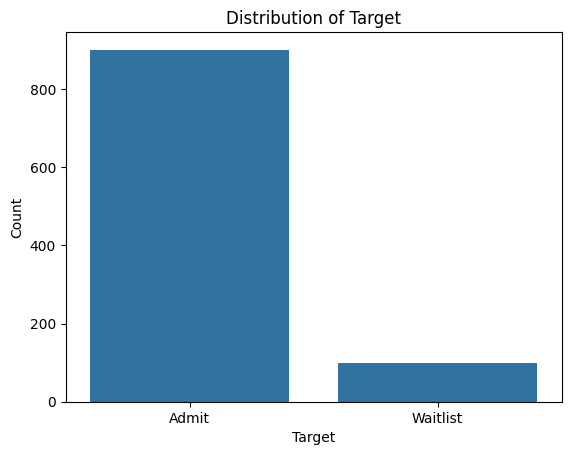

In [34]:
# Larning distribusi variabel target
distribution = df['admission'].value_counts()
# Menghitung persentase distribusi pada varibel target
distribution_percentage = df['admission'].value_counts(normalize=True) * 100

print(f'Label counts:\n{distribution}')
# Print the percentage distribution with the '%' symbol
distribution_percentage = distribution_percentage.round(2).astype(str) + '%'
print(f'Label percentages:\n{distribution_percentage}')

# visualisasi distribusi
sns.countplot(x='admission', data=df)
plt.title('Distribution of Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

2. Data prepartion


*   Menangani missing values
*   Split data
*   Define X, y get Dummy on X for categorical data
*   Deal imbalanced data
*   Scale data



In [35]:
df.head()

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


In [36]:
# Mengubah male ke 1 dan female ke 0
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# cek
print(df.head())

   gender  international   gpa       major      race   gmat  work_exp  \
0       0          False  3.30    Business     Asian  620.0       3.0   
1       1          False  3.28  Humanities     Black  680.0       5.0   
2       0           True  3.30    Business       NaN  710.0       5.0   
3       1          False  3.47        STEM     Black  690.0       6.0   
4       1          False  3.35        STEM  Hispanic  590.0       5.0   

           work_industry admission  
0     Financial Services     Admit  
1  Investment Management       NaN  
2             Technology     Admit  
3             Technology       NaN  
4             Consulting       NaN  


In [37]:
# Admission
# 1. hapus wailist
df = df[df['admission'] != 'Waitlist']

# 2. Ubah admit ke 1 dan emty atau null ke 0
df['admission'] = df['admission'].map({'Admit': 1}).fillna(0)

print(df.head())

   gender  international   gpa       major      race   gmat  work_exp  \
0       0          False  3.30    Business     Asian  620.0       3.0   
1       1          False  3.28  Humanities     Black  680.0       5.0   
2       0           True  3.30    Business       NaN  710.0       5.0   
3       1          False  3.47        STEM     Black  690.0       6.0   
4       1          False  3.35        STEM  Hispanic  590.0       5.0   

           work_industry  admission  
0     Financial Services        1.0  
1  Investment Management        0.0  
2             Technology        1.0  
3             Technology        0.0  
4             Consulting        0.0  


<ipython-input-37-c900fccfc0d1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['admission'] = df['admission'].map({'Admit': 1}).fillna(0)


In [52]:
# membagi majority dan minority classes
df_majority = df[df['admission'] == 0]  # Majority class (admission = 0)
df_minority = df[df['admission'] == 1]  # Minority class (admission = 1)

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # Sample tanpa replacement
                                   n_samples=len(df_minority),  # Match minority class size
                                   random_state=42)  # Reproducibility

# mengkombinasikan minority class dengan downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# mengacak the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify class distribution
print(df_balanced['admission'].value_counts())
print(df_balanced.head())

admission
1.0    900
0.0    900
Name: count, dtype: int64
   gender  international   gpa       major   race   gmat  work_exp  \
0       1          False  3.25  Humanities  White  670.0       6.0   
1       1          False  3.34  Humanities  White  700.0       4.0   
2       0          False  3.20        STEM  White  680.0       6.0   
3       1           True  3.18    Business    NaN  580.0       6.0   
4       1          False  3.33  Humanities  Asian  670.0       5.0   

        work_industry  admission  
0       Nonprofit/Gov        1.0  
1          Consulting        1.0  
2       Nonprofit/Gov        0.0  
3          Consulting        0.0  
4  Financial Services        1.0  


In [50]:
# memilih features dan target variable
X = df_balanced.drop('admission', axis = 1)
X = pd.get_dummies(X, drop_first = True)  # Apply one-hot encoding to categorical variables
y = df_balanced['admission']

In [49]:
# membagi training dan testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 3. Modeling

In [48]:
# membuat dan melatih Decision Tree model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# membuat prediksi pada set test
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

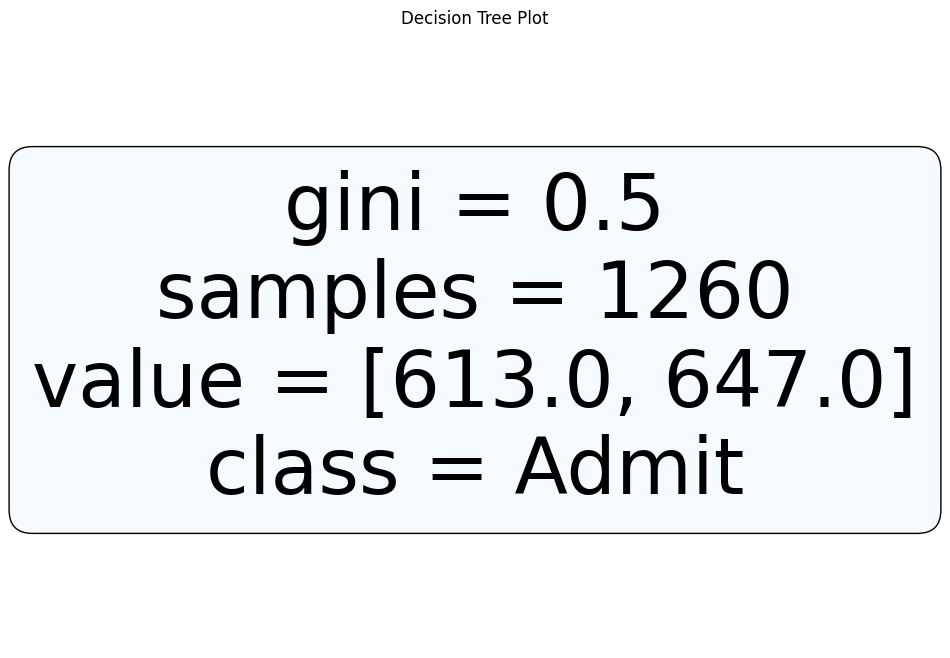

In [47]:
# Print decision tree
# Plot decision tree dengan plot_tree
plt.figure(figsize=(12, 8))  # Set the figure size
plot_tree(clf, filled=True, rounded=True, feature_names=X_train.columns, class_names=['Decline', 'Admit'])
plt.title('Decision Tree Plot')
plt.show()

### 4. Evaluation

Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.66      0.69       287
         1.0       0.65      0.71      0.68       253

    accuracy                           0.68       540
   macro avg       0.68      0.68      0.68       540
weighted avg       0.69      0.68      0.68       540

AUC-ROC: 0.68


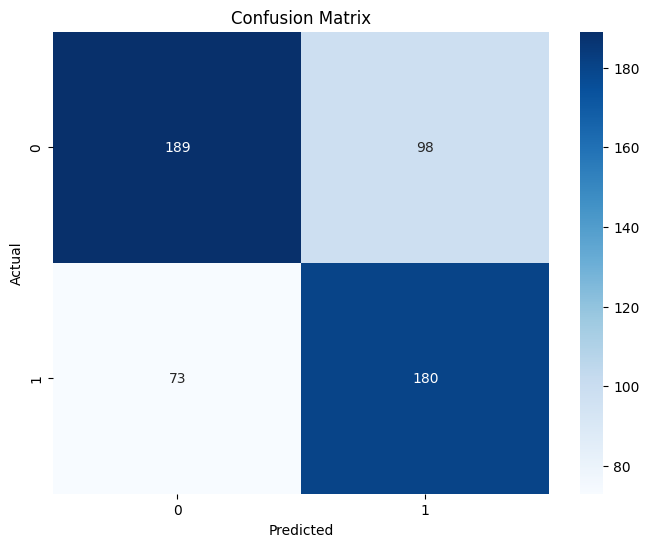

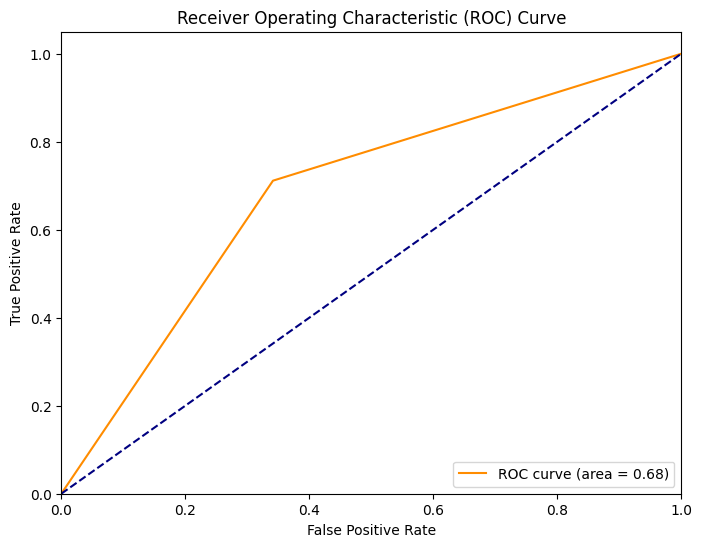

In [46]:
# Evaluasi Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Output
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(class_report)
print(f"AUC-ROC: {roc_auc:.2f}")

# Plot confusion matrix menggunaakan seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## 5. Tree Puring: CCP method

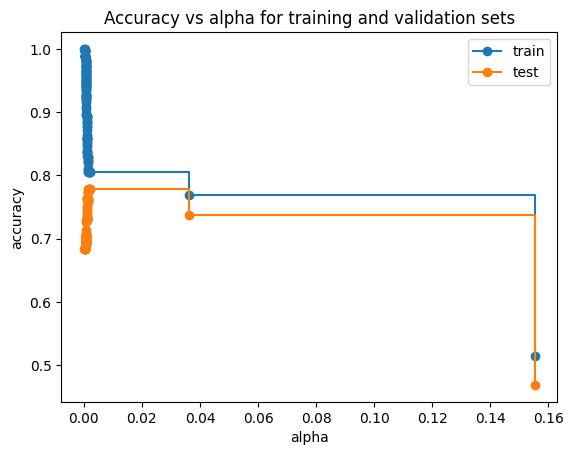

Best Alpha: 0.0021344057940437533
Test Accuracy: 77.778%


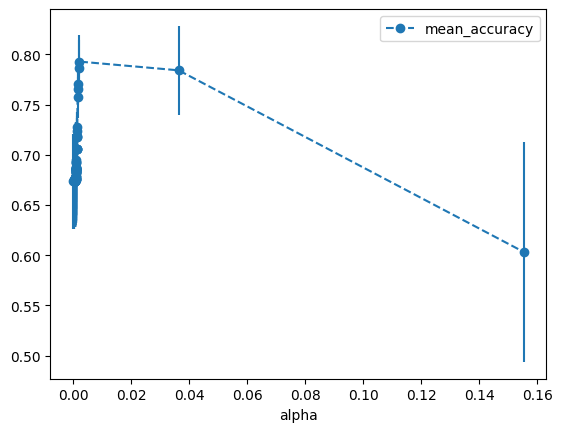

In [53]:
# Decision tree dengan CCP
#  Latih pohon keputusan awal untuk mendapatkan ccp_alphas
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Obtain the effective alphas and the corresponding total leaf impurities
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Decision tree dengan CCP
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# buat array untuk menyimpan hasil setiap lipatan selama validasi silang
alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])
alpha_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', linestyle='--')

# mencari and print the best alpha
best_alpha = alpha_results[alpha_results['mean_accuracy'] == max(alpha_results['mean_accuracy'])]['alpha'].values[0]
print("Best Alpha:", best_alpha)

# melatih final decision tree classifier dengan the best alpha
clf_dtr_ccp = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
clf_dtr_ccp.fit(X_train, y_train)

y_pred_ccp = clf_dtr_ccp.predict(X_test)
test_ccp_accuracy = accuracy_score(y_test, y_pred_ccp)
print(f"Test Accuracy: {test_ccp_accuracy:.3%}")

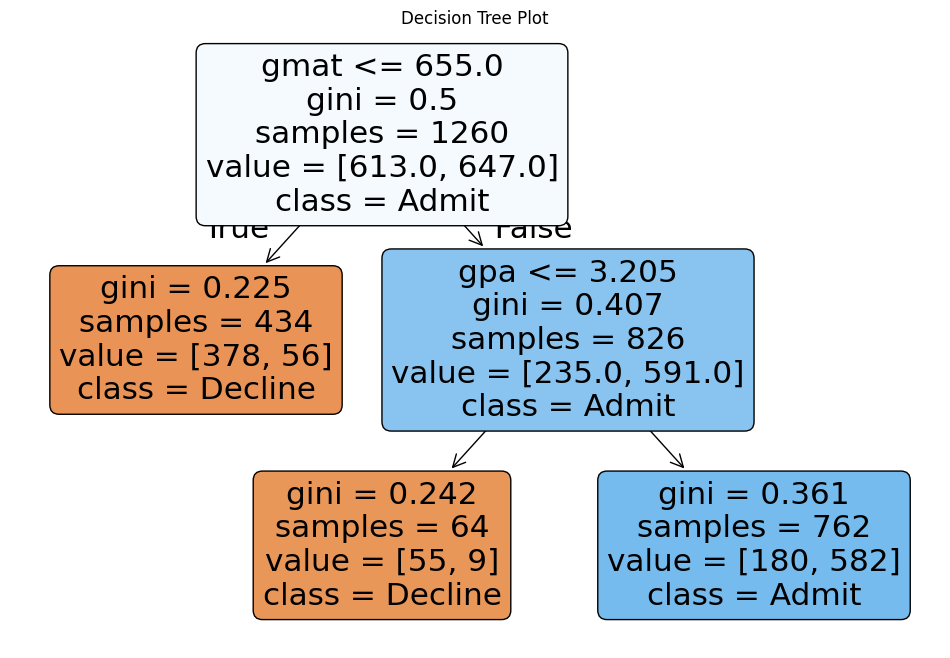

In [54]:
# Print the tree
# Plot decision tree menggunakan plot_tree
plt.figure(figsize=(12, 8))  # Set the figure size
plot_tree(clf_dtr_ccp, filled=True, rounded=True, feature_names=X_train.columns, class_names=['Decline', 'Admit'])
plt.title('Decision Tree Plot')
plt.show()

Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.69      0.77       287
         1.0       0.72      0.87      0.79       253

    accuracy                           0.78       540
   macro avg       0.79      0.78      0.78       540
weighted avg       0.79      0.78      0.78       540

AUC-ROC: 0.78


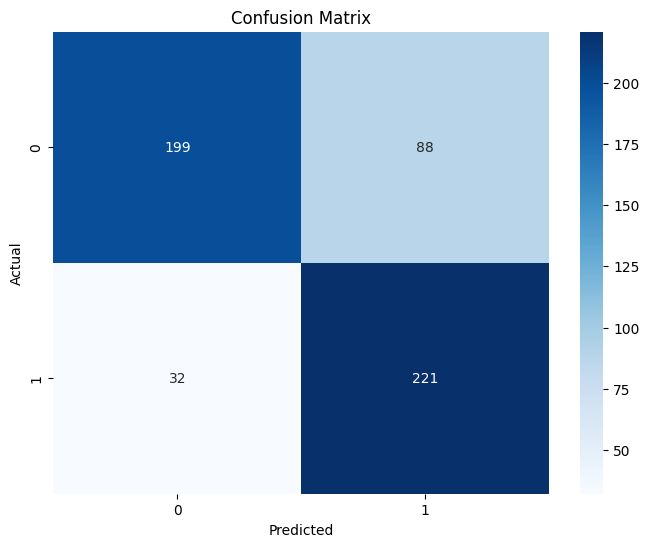

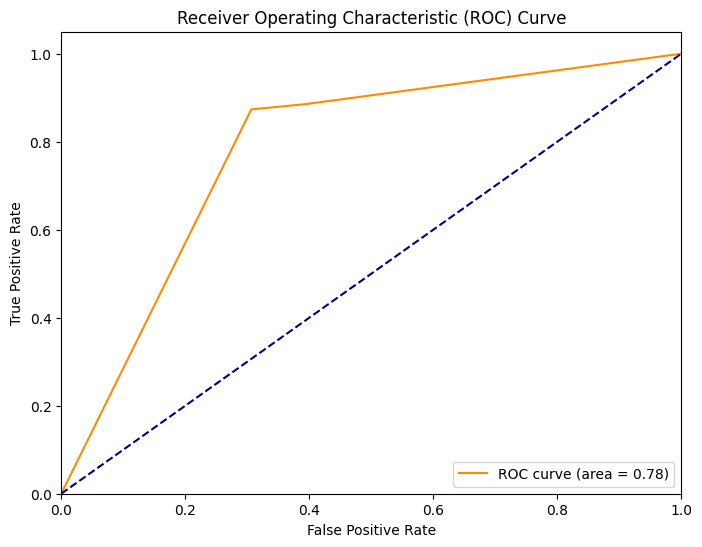

In [56]:
# Make predictions on the test set
y_pred = clf_dtr_ccp.predict(X_test)
y_prob = clf_dtr_ccp.predict_proba(X_test)[:, 1]

# evaluasi model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Output the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(class_report)
print(f"AUC-ROC: {roc_auc:.2f}")

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()